In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

# 1. Gather data

In [2]:
data = duckdb.query(
    """
    SELECT appl_id, 
           project_num_split.appl_type_code,
           str_split(project_num, '-')[1][2:] project_num_prefix,
           CAST(project_num_split.support_year AS INTEGER) support_year,
           fiscal_year,
           award_amount,
           project_end_date,
           budget_end,
           date_added
    FROM read_json('../../../data/json/projects/year_added=20*/*/*')
    WHERE year_added >= 2015
    ORDER BY project_num_prefix, budget_end
    """
).to_df()

data = data[~data.budget_end.isna()]

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

# 2. Current amount of lapsed non-competitive projects

The following code determines a lower bound for the the number of active non-competitive projects whose funding has lapsed, i.e the current week is past the `budget_end` date of the most recent entries. Active status is determined by the `project_end_date` being after the the cutoff date. I do my best to match the same time period accross years in order to make them comparable to each other. When looking at the total lapsed funding, it is important to note that this simple query may still be missing funding that is very likely to be renewed, but does not start with the 5 prefix.

Another major reason this is a lower bound is because it only focusses on the RePORTER entries which were added in the previous fiscal year. Subsequent analyses will likely add in data which reaches further back, but I am less confident in its analysis.

In [3]:
non_competitive_projects = data[data.appl_type_code == '5']

In [4]:
lapsed_project_statistics = pd.DataFrame(
    {
        "cutoff_dates": [
            datetime(2025, 3, 17),
            datetime(2024, 3, 17),
            datetime(2023, 3, 19),
            datetime(2022, 3, 20),
            datetime(2021, 3, 21),
            datetime(2020, 3, 22),
            datetime(2019, 3, 17),
            datetime(2018, 3, 18),
            datetime(2017, 3, 19),
            datetime(2016, 3, 22),
        ],
        "year": np.arange(2016, 2026)[::-1],
        "n_lapsed": np.zeros(10),
        "lapsed_award_amount_total": np.zeros(10)
    }
)

lapsed_project_statistics

,cutoff_dates,year,n_lapsed,lapsed_award_amount_total
0,2025-03-17,2025,0.0,0.0
1,2024-03-17,2024,0.0,0.0
2,2023-03-19,2023,0.0,0.0
3,2022-03-20,2022,0.0,0.0
4,2021-03-21,2021,0.0,0.0
5,2020-03-22,2020,0.0,0.0
6,2019-03-17,2019,0.0,0.0
7,2018-03-18,2018,0.0,0.0
8,2017-03-19,2017,0.0,0.0
9,2016-03-22,2016,0.0,0.0


In [5]:
for ind, cutoff_date in enumerate(lapsed_project_statistics.cutoff_dates):
    # 1. Select only
    select = np.logical_and(
        non_competitive_projects.date_added < cutoff_date,
        non_competitive_projects.fiscal_year >= cutoff_date.year - 1
    )
    non_competitive_projects_snapshot = non_competitive_projects[select]

    project_end = non_competitive_projects_snapshot.groupby("project_num_prefix").project_end_date.max()
    n_lapsed_entries = non_competitive_projects_snapshot[
            non_competitive_projects_snapshot.budget_end <= cutoff_date
        ].groupby("project_num_prefix").appl_id.count().rename("n_lapsed_entries")
    sum_lapsed_entries = non_competitive_projects_snapshot[
            non_competitive_projects_snapshot.budget_end <= cutoff_date
        ].groupby("project_num_prefix").award_amount.sum().rename("sum_lapsed_entries")
    n_funded_entries = non_competitive_projects_snapshot[
            non_competitive_projects_snapshot.budget_end >= cutoff_date
        ].groupby("project_num_prefix").appl_id.count().rename("n_funded_entries")

    joined_data = project_end.to_frame().join(n_lapsed_entries, how="right").join(sum_lapsed_entries, how="left").join(n_funded_entries, how="left")
    project_lapsed = np.logical_and(
        joined_data.project_end_date > cutoff_date,
        joined_data.n_funded_entries.isna()
    )
    lapsed_project_statistics.n_lapsed.values[ind] = project_lapsed.sum()
    lapsed_project_statistics.lapsed_award_amount_total.values[ind] = joined_data[project_lapsed].sum_lapsed_entries.sum()

In [6]:
lapsed_project_statistics.to_csv(
    "/home/jovyan/public/weekly/week_of_2025_03_16/data/lapsed_non_competitive_yearly_renewals_stats.csv",
    index = False
)
lapsed_project_statistics

,cutoff_dates,year,n_lapsed,lapsed_award_amount_total
0,2025-03-17,2025,1365.0,1.034085e+09
1,2024-03-17,2024,550.0,3.592695e+08
2,2023-03-19,2023,526.0,3.966426e+08
3,2022-03-20,2022,572.0,3.905883e+08
4,2021-03-21,2021,599.0,3.376110e+08
5,2020-03-22,2020,438.0,2.155520e+08
6,2019-03-17,2019,368.0,1.811981e+08
7,2018-03-18,2018,212.0,1.138025e+08
8,2017-03-19,2017,606.0,2.928803e+08
9,2016-03-22,2016,324.0,4.282789e+08


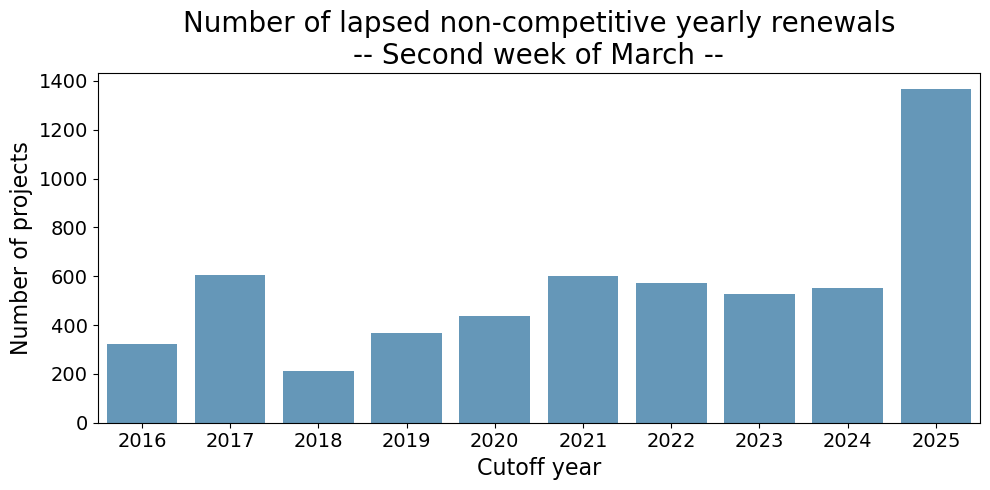

In [7]:
plt.figure(figsize=[10, 5])

sns.barplot(
    x = "year",
    y = "n_lapsed",
    data = lapsed_project_statistics,
    alpha = .75
)

plt.xlabel("Cutoff year", size=16)
plt.ylabel("Number of projects", size=16)
plt.tick_params(labelsize=14)
plt.title(
    "Number of lapsed non-competitive yearly renewals\n-- Second week of March --",
    size=20
)
plt.tight_layout()
plt.savefig(
    "/home/jovyan/public/weekly/week_of_2025_03_16/figures/lapsed_non_competitive_yearly_renewal_count.png",
    dpi = 300
)
plt.show()

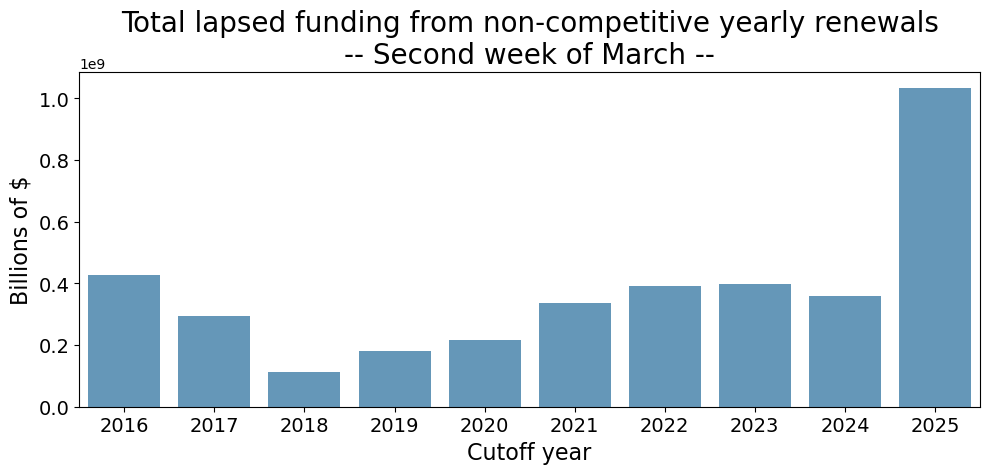

In [8]:
plt.figure(figsize=[10, 5])

sns.barplot(
    x = "year",
    y = "lapsed_award_amount_total",
    data = lapsed_project_statistics,
    alpha = .75
)

plt.xlabel("Cutoff year", size=16)
plt.ylabel("Billions of $", size=16)
plt.tick_params(labelsize=14)
plt.title(
    "Total lapsed funding from non-competitive yearly renewals\n-- Second week of March --",
    size=20
)
plt.tight_layout()
plt.savefig(
    "/home/jovyan/public/weekly/week_of_2025_03_16/figures/lapsed_non_competitive_yearly_renewal_funding.png",
    dpi = 300
)
plt.show()